# Air Quality Index Prediction Using Regression Models

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor

### Load the Dataset

In [2]:
# Read the Excel file into a DataFrame
try:
    air_quality = pd.read_csv("Datasets/air-quality-dataset-India.csv")
    print("Dataset loaded successfully.")
except Exception as e:
    print("An error occurred:", e)

Dataset loaded successfully.


### Exploratory Data Analysis & Data Preprocessing

#### 1. Head of the Dataset - First Five Rows

In [3]:
air_quality

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory


#### 2. Determine Rows and Columns 

In [4]:
air_quality.shape

(29531, 16)

#### 3. Dataset Column Information

In [5]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


#### 4. Hanlde Null Values

In [6]:
air_quality.isna().sum()/air_quality.shape[0]

City          0.000000
Date          0.000000
PM2.5         0.155701
PM10          0.377231
NO            0.121296
NO2           0.121398
NOx           0.141715
NH3           0.349734
CO            0.069723
SO2           0.130507
O3            0.136196
Benzene       0.190410
Toluene       0.272290
Xylene        0.613220
AQI           0.158511
AQI_Bucket    0.158511
dtype: float64

Now, We Drop the rows where the AQI values are null

In [7]:
air_quality = air_quality.dropna(subset=['AQI'])
air_quality.isna().sum()/air_quality.shape[0]

City          0.000000
Date          0.000000
PM2.5         0.027284
PM10          0.285151
NO            0.015573
NO2           0.015734
NOx           0.074728
NH3           0.263018
CO            0.017907
SO2           0.024346
O3            0.032475
Benzene       0.142254
Toluene       0.234447
Xylene        0.618592
AQI           0.000000
AQI_Bucket    0.000000
dtype: float64

The columns who have 10% null, we drop thier rows. And for others we imputed the mean values  

In [8]:
columns_to_remove_null_rows = [col for col in air_quality.columns if air_quality[col].isna().mean() <= 0.1 and air_quality[col].isna().any()]

columns_to_impute = [col for col in air_quality.columns if col not in columns_to_remove_null_rows and air_quality[col].isna().any()]

print("Columns to remove rows with null values:", columns_to_remove_null_rows)
print("Columns to impute:", columns_to_impute)


Columns to remove rows with null values: ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']
Columns to impute: ['PM10', 'NH3', 'Benzene', 'Toluene', 'Xylene']


In [9]:
def remove_rows(data, column):
  return data[data[column].isna()==False]

for i in columns_to_remove_null_rows:
  air_quality = remove_rows(air_quality, i)

imputer = SimpleImputer()
air_quality[columns_to_impute] = imputer.fit_transform(air_quality[columns_to_impute])

In [10]:
air_quality.isna().sum()/air_quality.shape[0]

City          0.0
Date          0.0
PM2.5         0.0
PM10          0.0
NO            0.0
NO2           0.0
NOx           0.0
NH3           0.0
CO            0.0
SO2           0.0
O3            0.0
Benzene       0.0
Toluene       0.0
Xylene        0.0
AQI           0.0
AQI_Bucket    0.0
dtype: float64

#### 5. Drop city and Date column 

In [11]:
air_quality = air_quality.drop(columns=['City','Date'])

#### 6. Normalize the Distribution of Each Column 

C:\Users\asadm\AppData\Local\Temp\ipykernel_24084\3999187696.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plotting style


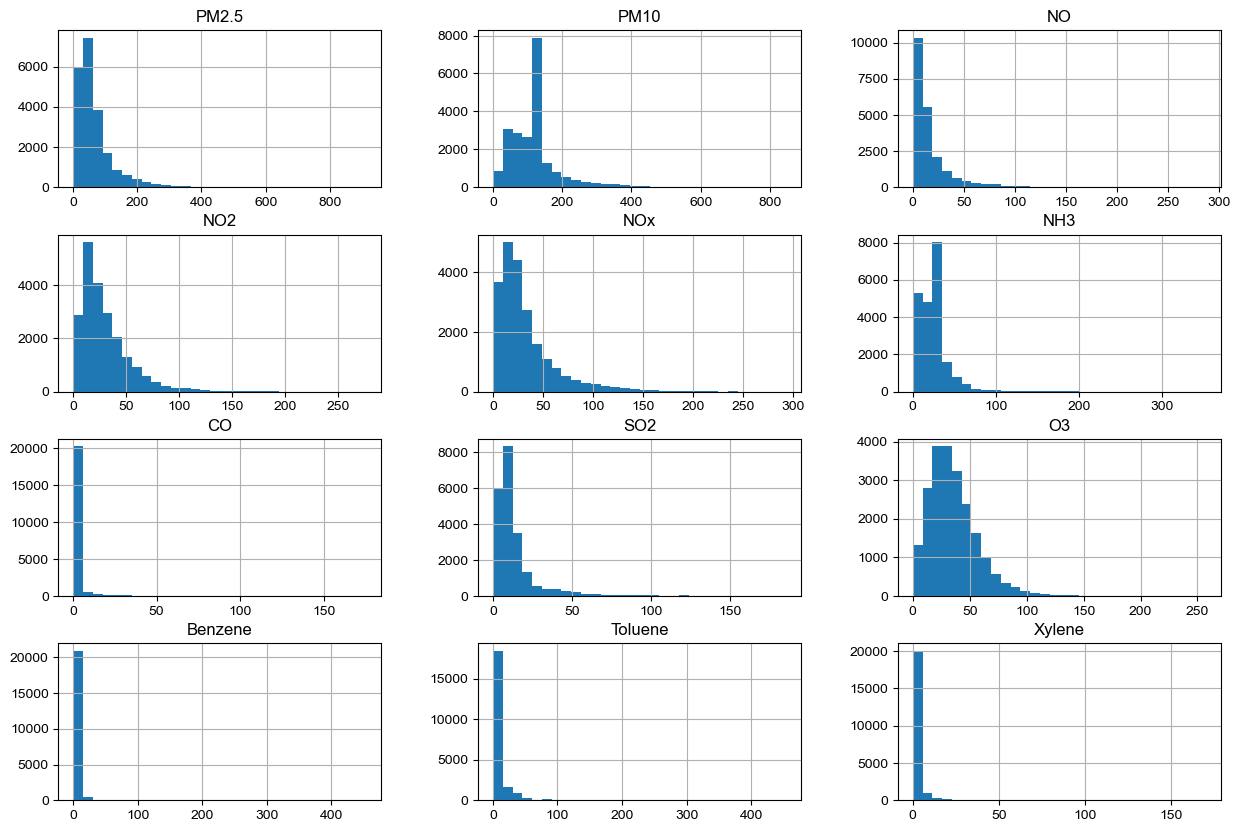

In [12]:
columns_to_plot = [col for col in air_quality.columns if col not in ["AQI_Bucket", "AQI"]]

air_quality[columns_to_plot].hist(bins=30, figsize=(15, 10))
plt.style.use('seaborn')  # Set the plotting style
plt.show()

In [13]:
columns_to_binarize = ['Benzene','Toluene','Xylene']
columns_to_yeo = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3']

binarize_threshold = {
    'Benzene': 30,
    'Xylene': 30,
    'Toluene': 30,
}

dataset_yeoTest = air_quality[[i for i in air_quality.columns if i not in ["AQI_Bucket","AQI"]]].copy()

def binarize(value, threshold):
    return 0 if value <= threshold else 1

for col in columns_to_binarize:
    new_col = col + "_binarized"
    air_quality[new_col] = air_quality[col].apply(binarize, threshold = binarize_threshold[col])
    
for col in columns_to_yeo:
    air_quality[col], _ = stats.yeojohnson(dataset_yeoTest[col])

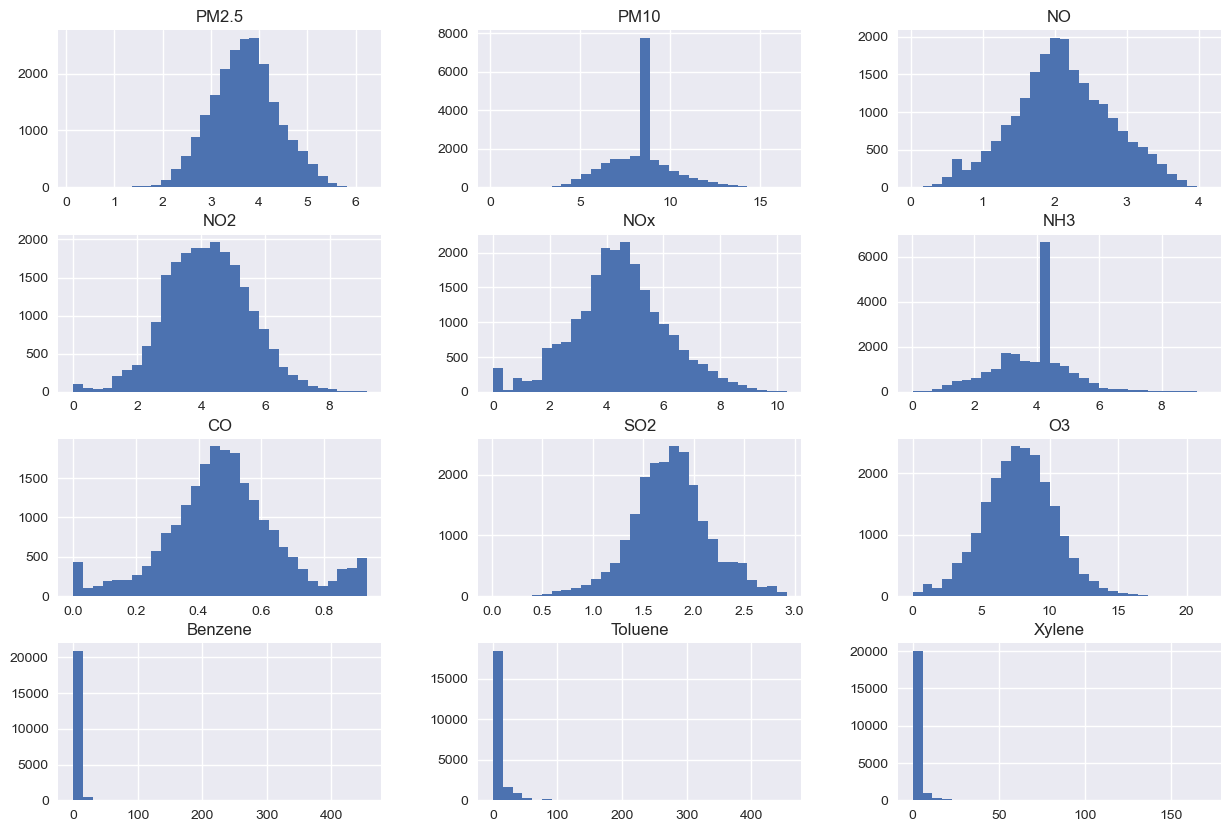

In [14]:
air_quality[columns_to_plot].hist(bins=30, figsize=(15, 10))
plt.show()

#### 7. Determine the Correlation of Features

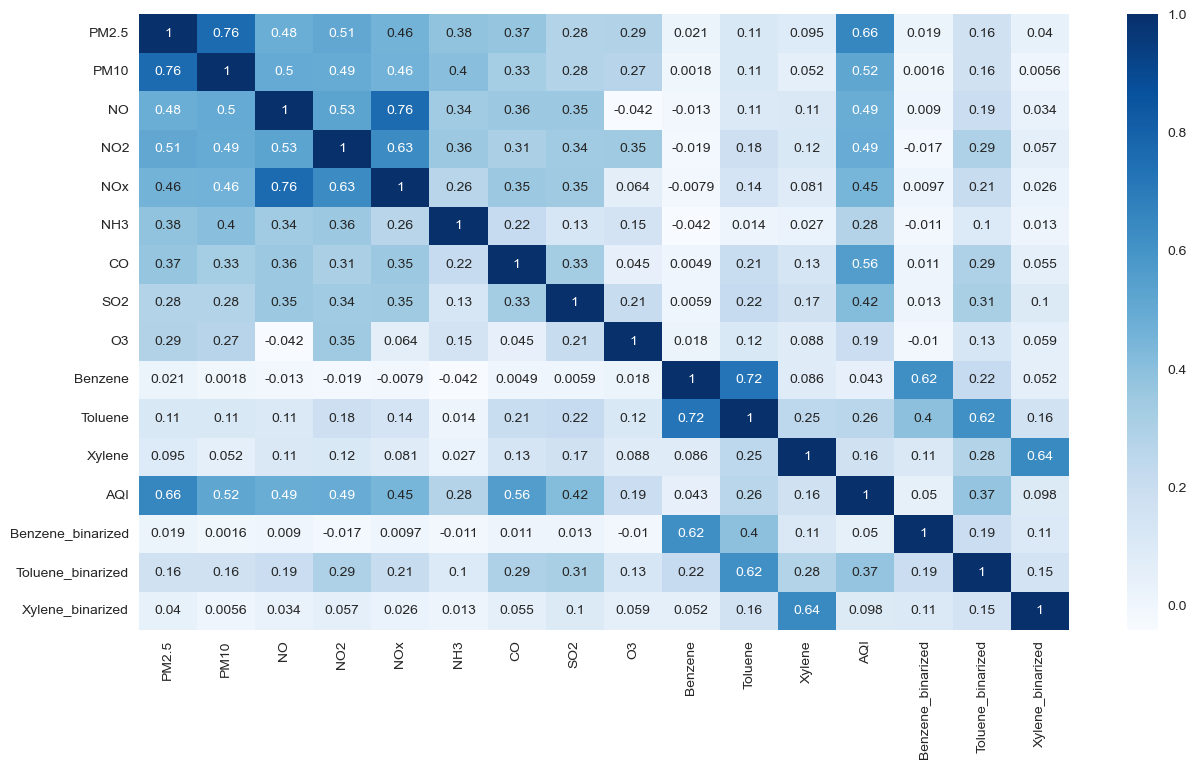

In [15]:
plt.figure(figsize=(15, 8))
cor = air_quality.drop(columns=["AQI_Bucket"]).corr()
sns.heatmap(cor, annot=True, cmap="Blues")
plt.show()

In [16]:
air_quality.drop(columns = columns_to_binarize + ['NOx'], inplace=True)

#### 8. Train Test Split

In [17]:
air_quality['AQI'] = np.log(air_quality['AQI'])

features = air_quality.drop(columns=["AQI", "AQI_Bucket"])
target   = air_quality["AQI"]

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 100)

print ("Training Dataset Shape : ", X_train.shape, " | | ", y_train.shape)

print ("Testing Dataset Shape : ", X_test.shape, " | | ", y_test.shape)

Training Dataset Shape :  (17273, 11)  | |  (17273,)
Testing Dataset Shape :  (4319, 11)  | |  (4319,)


#### 9. Scalling Features Data

In [18]:
standardScaler = StandardScaler()

X_train = standardScaler.fit_transform(X_train)
X_test  = standardScaler.transform(X_test)

### Linear Regression Modelling

#### 1. Linear Regression

In [19]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)

LinearRegression()

In [20]:
linearRegression_Pred = linearRegression.predict(X_test)
linearRegression_MSE  = mean_squared_error(y_test, linearRegression_Pred)
linearRegression_RMSE = mean_squared_error(y_test, linearRegression_Pred, squared=False)
linearRegression_MAE  = mean_absolute_error(y_test, linearRegression_Pred)
linearRegression_R2   = r2_score(y_test, linearRegression_Pred)

# Print the calculated metrics
print(f"Mean Squared Error (MSE): {linearRegression_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {linearRegression_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {linearRegression_MAE:.4f}")
print(f"R-squared (R2): {linearRegression_R2:.4f}")

Mean Squared Error (MSE): 0.0882
Root Mean Squared Error (RMSE): 0.2970
Mean Absolute Error (MAE): 0.2245
R-squared (R2): 0.8054


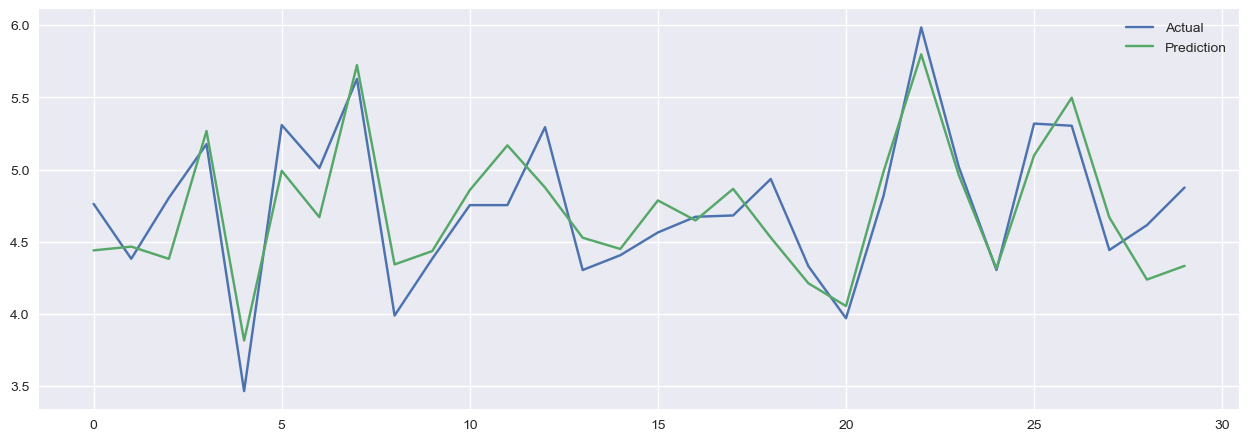

In [21]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, linearRegression_Pred[:30], label='Prediction')
axes.legend()
plt.show()

#### 2. Lasso Regression

In [22]:
lassoRegression = Lasso(alpha=0.1)
lassoRegression.fit(X_train, y_train)

Lasso(alpha=0.1)

In [23]:
lassoRegression_Pred = lassoRegression.predict(X_test)
lassoRegression_MSE  = mean_squared_error(y_test, lassoRegression_Pred)
lassoRegression_RMSE = mean_squared_error(y_test, lassoRegression_Pred, squared=False)
lassoRegression_MAE  = mean_absolute_error(y_test, lassoRegression_Pred)
lassoRegression_R2   = r2_score(y_test, lassoRegression_Pred)

# Print the calculated metrics
print(f"Mean Squared Error (MSE): {lassoRegression_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {lassoRegression_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {lassoRegression_MAE:.4f}")
print(f"R-squared (R2): {lassoRegression_R2:.4f}")

Mean Squared Error (MSE): 0.1098
Root Mean Squared Error (RMSE): 0.3314
Mean Absolute Error (MAE): 0.2505
R-squared (R2): 0.7578


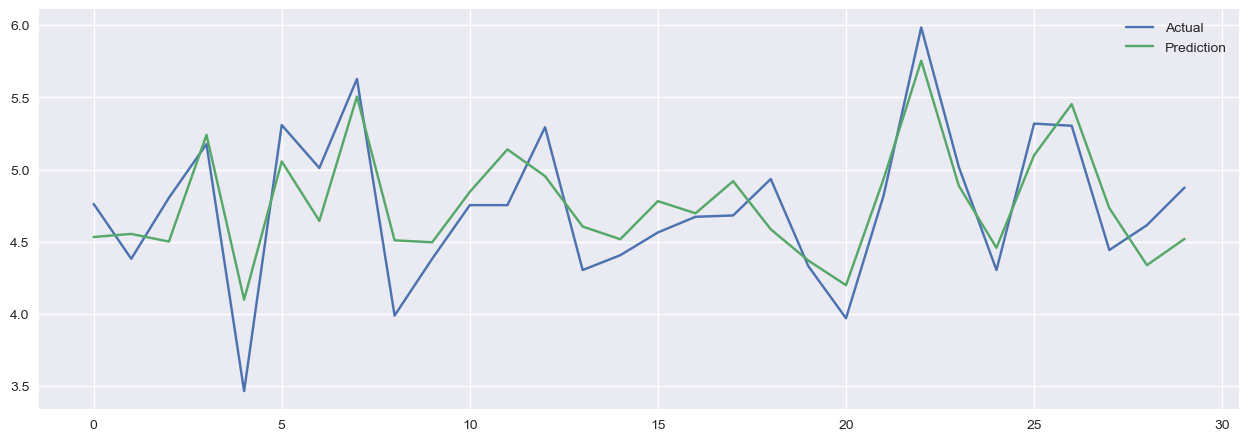

In [24]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, lassoRegression_Pred[:30], label='Prediction')
axes.legend()
plt.show()

#### 3. Ridge Regression

In [25]:
ridgeRegression = Ridge(alpha = 1)
ridgeRegression.fit(X_train, y_train)

Ridge(alpha=1)

In [26]:
ridgeRegression_Pred = ridgeRegression.predict(X_test)
ridgeRegression_MSE  = mean_squared_error(y_test, ridgeRegression_Pred)
ridgeRegression_RMSE = mean_squared_error(y_test, ridgeRegression_Pred, squared=False)
ridgeRegression_MAE  = mean_absolute_error(y_test, ridgeRegression_Pred)
ridgeRegression_R2   = r2_score(y_test, ridgeRegression_Pred)

# Print the calculated metrics
print(f"Mean Squared Error (MSE): {ridgeRegression_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {ridgeRegression_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {ridgeRegression_MAE:.4f}")
print(f"R-squared (R2): {ridgeRegression_R2:.4f}")

Mean Squared Error (MSE): 0.0882
Root Mean Squared Error (RMSE): 0.2970
Mean Absolute Error (MAE): 0.2245
R-squared (R2): 0.8054


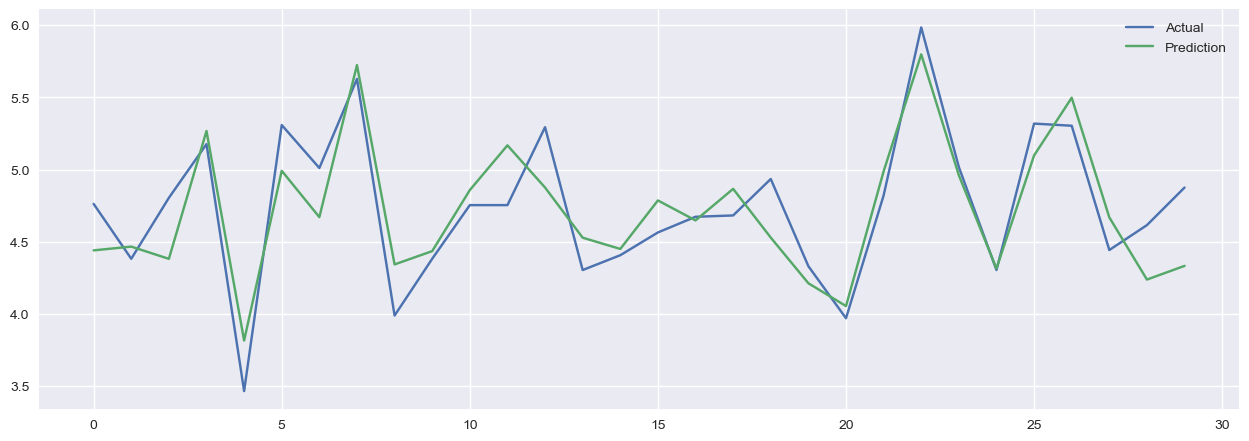

In [27]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, ridgeRegression_Pred[:30], label='Prediction')
axes.legend()
plt.show()

### Ensemble Regression Modelling - Hypertuning

#### 1. Random Forest Regressor

In [28]:
# Define the hyperparameter grid
paramGridRandomForest = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest Regressor
randomForest_Regressor = RandomForestRegressor(random_state=100)

# Create the GridSearchCV object
randomForestGridSearch = GridSearchCV(estimator  = randomForest_Regressor,
                           param_grid = paramGridRandomForest,
                           cv = 5,
                           n_jobs = -1,
                           scoring='neg_mean_squared_error')

# Fit the model with the best hyperparameters
randomForestGridSearch.fit(X_train, y_train)

# Get the best estimator
best_rf_regressor = randomForestGridSearch.best_estimator_

# Get the best parameters
rf_best_param = randomForestGridSearch.best_params_

In [29]:
# Predict using the best model
randomForest_Pred = best_rf_regressor.predict(X_test)

# Calculate evaluation metrics
randomForest_MSE  = mean_squared_error(y_test, randomForest_Pred)
randomForest_RMSE = mean_squared_error(y_test, randomForest_Pred, squared=False)
randomForest_MAE  = mean_absolute_error(y_test, randomForest_Pred)
randomForest_R2   = r2_score(y_test, randomForest_Pred)

# Print the calculated metrics
print(f"Best Parameters: {rf_best_param}")
print(f"Mean Squared Error (MSE): {randomForest_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {randomForest_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {randomForest_MAE:.4f}")
print(f"R-squared (R2): {randomForest_R2:.4f}")

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE): 0.0343
Root Mean Squared Error (RMSE): 0.1852
Mean Absolute Error (MAE): 0.1266
R-squared (R2): 0.9243


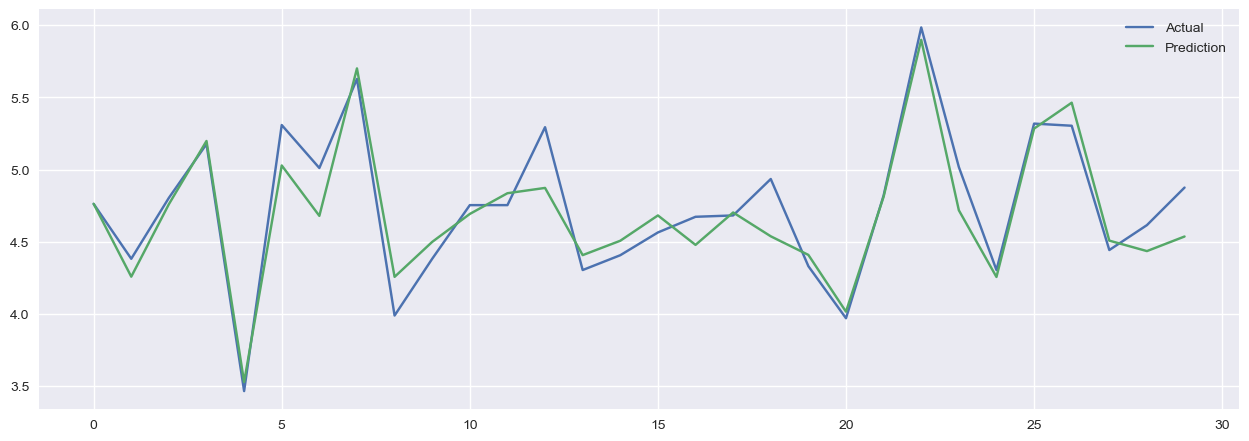

In [30]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, randomForest_Pred[:30], label='Prediction')
axes.legend()
plt.show()

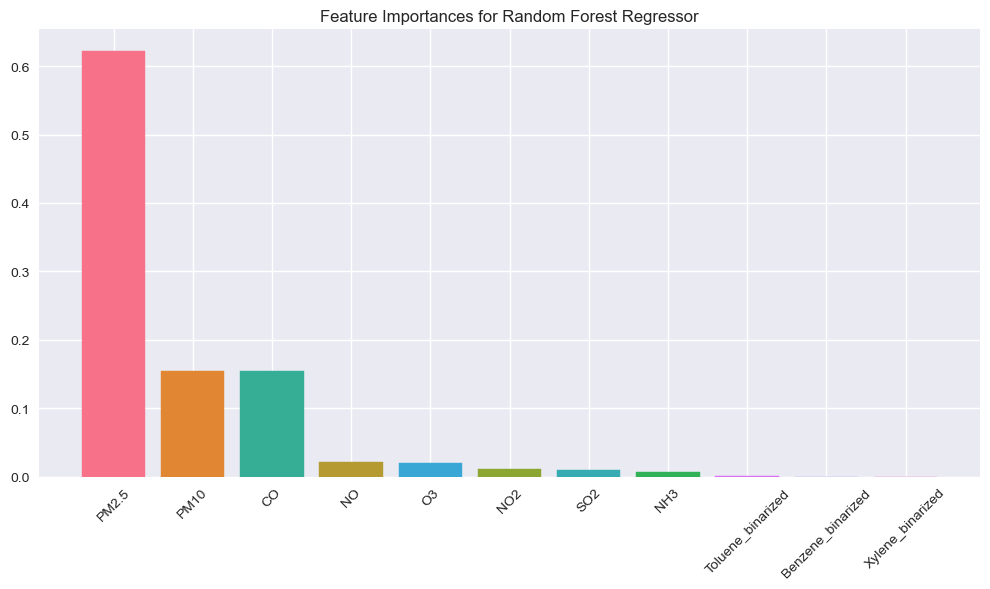

In [56]:
# Get feature importances
feature_importances = best_rf_regressor.feature_importances_

# Sort feature importances in descending order and get the corresponding feature names
sorted_idx = feature_importances.argsort()[::-1]
feature_names = features.columns.tolist()  # Replace with your own feature names

# Define a custom color palette using Seaborn
n_colors = len(feature_names)
custom_palette = sns.color_palette("husl", n_colors=n_colors)

# Create a dictionary that maps feature names to colors
feature_colors = {feature_names[i]: custom_palette[i] for i in range(n_colors)}

# Plot feature importances with the custom color palette
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Random Forest Regressor")
bars = plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
for i, bar in enumerate(bars):
    feature_name = feature_names[sorted_idx[i]]
    color = feature_colors.get(feature_name, 'k')  # Default to black ('k') if color is not specified
    bar.set_color(color)
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.tight_layout()
plt.show()

#### 2. AdaBoost Regressor

In [35]:
# Define the hyperparameter grid
paramGridAdaBoost = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Create the AdaBoost Regressor
adaBoostRegressor = AdaBoostRegressor(random_state=100)

# Create the GridSearchCV object
adaBoostGridSearch = GridSearchCV(estimator = adaBoostRegressor,
                                  param_grid = paramGridAdaBoost,
                                  cv = 5,
                                  n_jobs = -1,
                                  scoring='neg_mean_squared_error')

# Fit the model with the best hyperparameters
adaBoostGridSearch.fit(X_train, y_train)

# Get the best estimator
best_ada_regressor = adaBoostGridSearch.best_estimator_

# Get the best parameters
ada_best_param = adaBoostGridSearch.best_params_

In [36]:
# Predict using the best model
adaBoost_Pred = best_ada_regressor.predict(X_test)

# Calculate evaluation metrics
adaBoost_MSE  = mean_squared_error(y_test, adaBoost_Pred)
adaBoost_RMSE = mean_squared_error(y_test, adaBoost_Pred, squared=False)
adaBoost_MAE  = mean_absolute_error(y_test, adaBoost_Pred)
adaBoost_R2   = r2_score(y_test, adaBoost_Pred)

# Print the calculated metrics
print(f"Best Parameters: {ada_best_param}")
print(f"Mean Squared Error (MSE): {adaBoost_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {adaBoost_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {adaBoost_MAE:.4f}")
print(f"R-squared (R2): {adaBoost_R2:.4f}")

Best Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Mean Squared Error (MSE): 0.0695
Root Mean Squared Error (RMSE): 0.2635
Mean Absolute Error (MAE): 0.2017
R-squared (R2): 0.8468


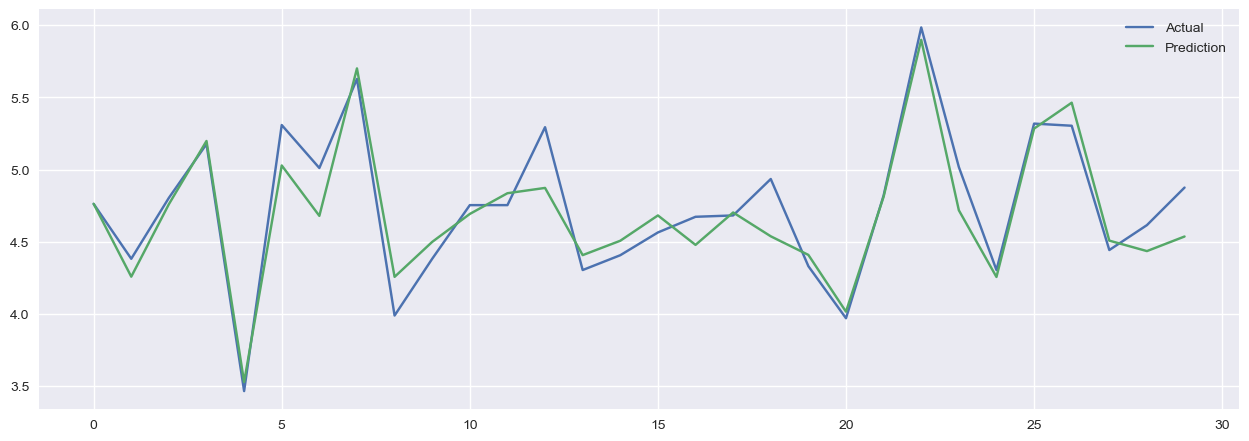

In [37]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, randomForest_Pred[:30], label='Prediction')
axes.legend()
plt.show()

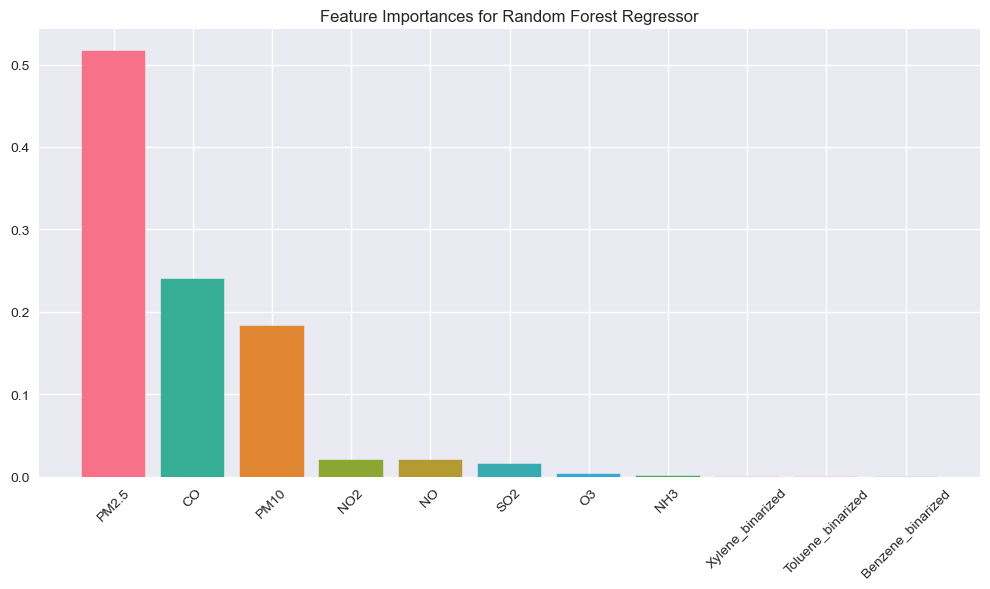

In [57]:
# Get feature importances
feature_importances = best_ada_regressor.feature_importances_

# Sort feature importances in descending order and get the corresponding feature names
sorted_idx = feature_importances.argsort()[::-1]
feature_names = features.columns.tolist()  # Replace with your own feature names

# Define a custom color palette using Seaborn
n_colors = len(feature_names)
custom_palette = sns.color_palette("husl", n_colors=n_colors)

# Create a dictionary that maps feature names to colors
feature_colors = {feature_names[i]: custom_palette[i] for i in range(n_colors)}

# Plot feature importances with the custom color palette
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Random Forest Regressor")
bars = plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
for i, bar in enumerate(bars):
    feature_name = feature_names[sorted_idx[i]]
    color = feature_colors.get(feature_name, 'k')  # Default to black ('k') if color is not specified
    bar.set_color(color)
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.tight_layout()
plt.show()

#### 3. Bagging Regressor

In [40]:
# Define the hyperparameter grid
paramGridBagging = {
    'n_estimators': [100, 200],
    'max_samples': [1.0, 0.8],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Create the Bagging Regressor
baggingRegressor = BaggingRegressor(random_state=100)

# Create the GridSearchCV object
baggingGridSearch = GridSearchCV(
    estimator=baggingRegressor,
    param_grid=paramGridBagging,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the model with the best hyperparameters
baggingGridSearch.fit(X_train, y_train)

# Get the best estimator
best_bag_regressor = baggingGridSearch.best_estimator_

# Get the best parameters
bag_best_param = baggingGridSearch.best_params_

In [41]:
# Predict using the best model
bagging_Pred = best_bag_regressor.predict(X_test)

# Calculate evaluation metrics
bagging_MSE = mean_squared_error(y_test, bagging_Pred)
bagging_RMSE = mean_squared_error(y_test, bagging_Pred, squared=False)
bagging_MAE = mean_absolute_error(y_test, bagging_Pred)
bagging_R2 = r2_score(y_test, bagging_Pred)

# Print the calculated metrics
print(f"Best Parameters: {bag_best_param}")
print(f"Mean Squared Error (MSE): {bagging_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {bagging_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {bagging_MAE:.4f}")
print(f"R-squared (R2): {bagging_R2:.4f}")

Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.8, 'n_estimators': 200}
Mean Squared Error (MSE): 0.0341
Root Mean Squared Error (RMSE): 0.1846
Mean Absolute Error (MAE): 0.1255
R-squared (R2): 0.9248


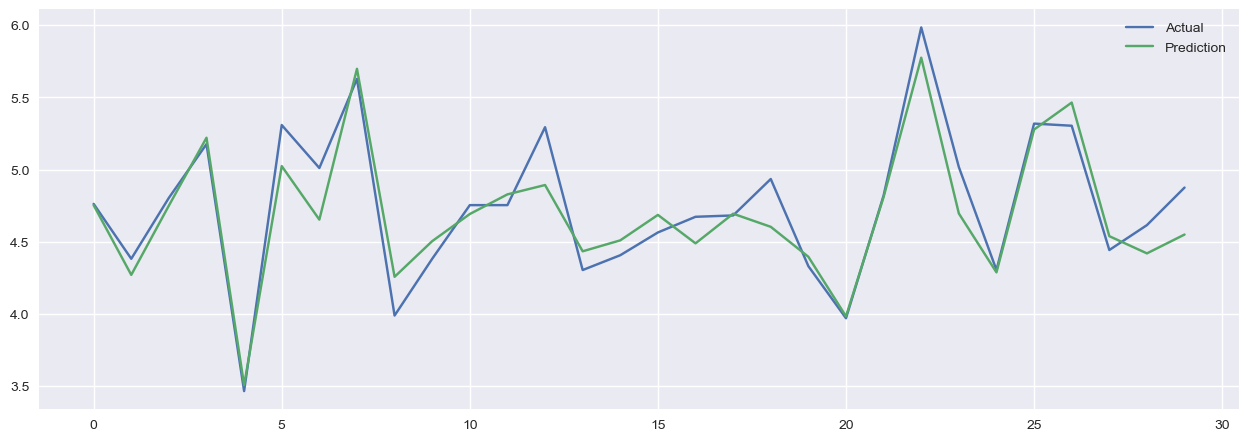

In [42]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, bagging_Pred[:30], label='Prediction')
axes.legend()
plt.show()

In [43]:
# Get feature importances
feature_importances = best_bag_regressor.feature_importances_

# Sort feature importances in descending order and get the corresponding feature names
sorted_idx = feature_importances.argsort()[::-1]
feature_names = features.columns.tolist()  # Replace with your own feature names

# Print feature importances
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importances[i]}")

# Plot feature importances (optional)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.tight_layout()
plt.show()

AttributeError: 'BaggingRegressor' object has no attribute 'feature_importances_'

#### 4. ExtraTrees Regressor

In [44]:
# Define the hyperparameter grid
paramGridExtraTrees = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Extra Trees Regressor
extraTreesRegressor = ExtraTreesRegressor(random_state=100)

# Create the GridSearchCV object
extraTreesGridSearch = GridSearchCV(estimator = extraTreesRegressor, 
                                    param_grid = paramGridExtraTrees,
                                    cv = 5,
                                    n_jobs = -1,
                                    scoring = 'neg_mean_squared_error')

# Fit the model with the best hyperparameters
extraTreesGridSearch.fit(X_train, y_train)

# Get the best estimator
best_extra_trees_regressor = extraTreesGridSearch.best_estimator_

# Get the best parameters
extra_trees_best_param = extraTreesGridSearch.best_params_

In [45]:
# Predict using the best model
extra_trees_Pred = best_extra_trees_regressor.predict(X_test)

# Calculate evaluation metrics
extra_trees_MSE = mean_squared_error(y_test, extra_trees_Pred)
extra_trees_RMSE = mean_squared_error(y_test, extra_trees_Pred, squared=False)
extra_trees_MAE = mean_absolute_error(y_test, extra_trees_Pred)
extra_trees_R2 = r2_score(y_test, extra_trees_Pred)

# Print the calculated metrics
print(f"Best Parameters: {extra_trees_best_param}")
print(f"Mean Squared Error (MSE): {extra_trees_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {extra_trees_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {extra_trees_MAE:.4f}")
print(f"R-squared (R2): {extra_trees_R2:.4f}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error (MSE): 0.0327
Root Mean Squared Error (RMSE): 0.1809
Mean Absolute Error (MAE): 0.1230
R-squared (R2): 0.9278


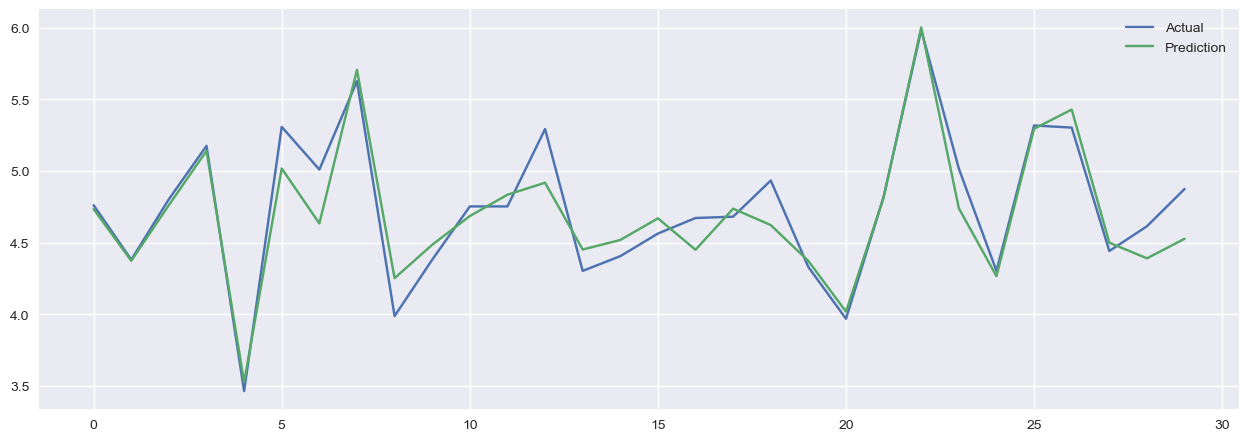

In [46]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, extra_trees_Pred[:30], label='Prediction')
axes.legend()
plt.show()

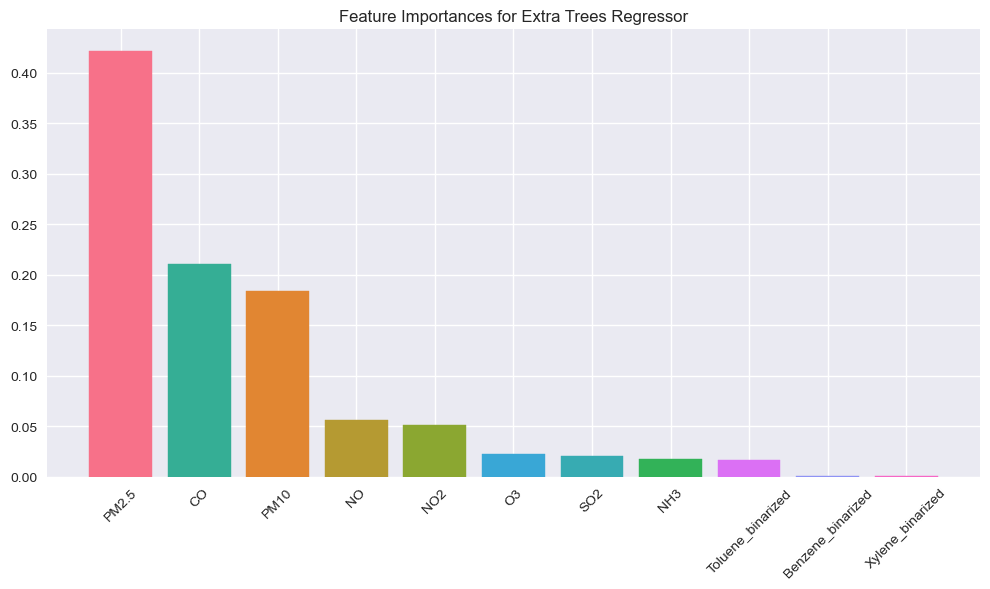

In [55]:
# Get feature importances
feature_importances = best_extra_trees_regressor.feature_importances_

# Sort feature importances in descending order and get the corresponding feature names
sorted_idx = feature_importances.argsort()[::-1]
feature_names = features.columns.tolist()  # Replace with your own feature names

# Define a custom color palette using Seaborn
n_colors = len(feature_names)
custom_palette = sns.color_palette("husl", n_colors=n_colors)

# Create a dictionary that maps feature names to colors
feature_colors = {feature_names[i]: custom_palette[i] for i in range(n_colors)}

# Plot feature importances with the custom color palette
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Extra Trees Regressor")
bars = plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
for i, bar in enumerate(bars):
    feature_name = feature_names[sorted_idx[i]]
    color = feature_colors.get(feature_name, 'k')  # Default to black ('k') if color is not specified
    bar.set_color(color)
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.tight_layout()
plt.show()

#### 5. Gradient Boosting Regressor

In [48]:
# Define the hyperparameter grid
paramGridGradientBoosting = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Gradient Boosting Regressor
gradientBoostingRegressor = GradientBoostingRegressor(random_state=100)

# Create the GridSearchCV object
gradientBoostingGridSearch = GridSearchCV(estimator  = gradientBoostingRegressor,
                                          param_grid = paramGridGradientBoosting,
                                          cv = 5,
                                          n_jobs = -1,
                                          scoring = 'neg_mean_squared_error')

# Fit the model with the best hyperparameters
gradientBoostingGridSearch.fit(X_train, y_train)

# Get the best estimator
best_gradient_boosting_regressor = gradientBoostingGridSearch.best_estimator_

# Get the best parameters
gradient_boosting_best_param = gradientBoostingGridSearch.best_params_

In [49]:
# Predict using the best model
gradient_boosting_Pred = best_gradient_boosting_regressor.predict(X_test)

# Calculate evaluation metrics
gradient_boosting_MSE = mean_squared_error(y_test, gradient_boosting_Pred)
gradient_boosting_RMSE = mean_squared_error(y_test, gradient_boosting_Pred, squared=False)
gradient_boosting_MAE = mean_absolute_error(y_test, gradient_boosting_Pred)
gradient_boosting_R2 = r2_score(y_test, gradient_boosting_Pred)

# Print the calculated metrics
print(f"Best Parameters: {gradient_boosting_best_param}")
print(f"Mean Squared Error (MSE): {gradient_boosting_MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {gradient_boosting_RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {gradient_boosting_MAE:.4f}")
print(f"R-squared (R2): {gradient_boosting_R2:.4f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE): 0.0349
Root Mean Squared Error (RMSE): 0.1868
Mean Absolute Error (MAE): 0.1306
R-squared (R2): 0.9231


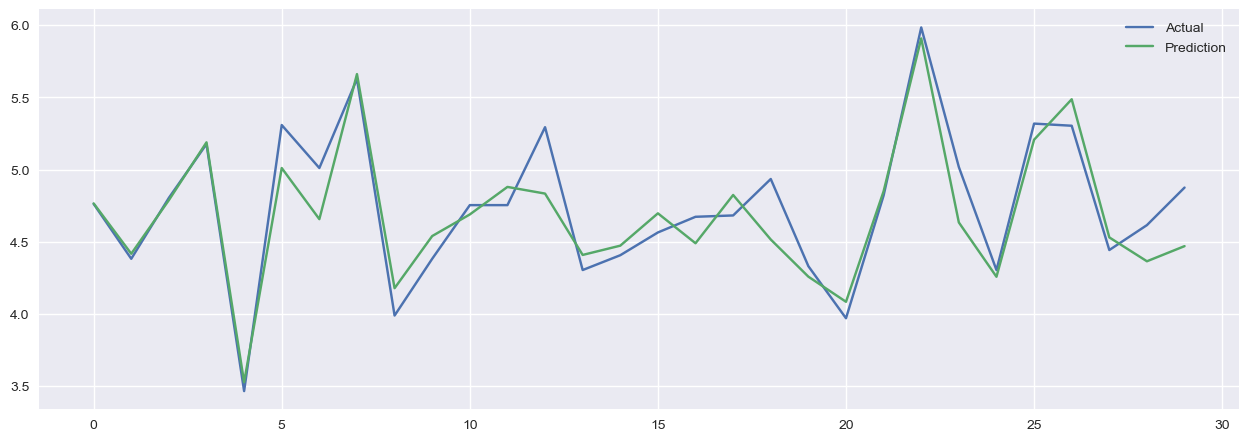

In [50]:
fig = plt.figure(figsize=(12, 4))

axes = fig.add_axes([0, 0, 1, 1])  
x = range(30)  
axes.plot(x, y_test[:30], label='Actual')
axes.plot(x, gradient_boosting_Pred[:30], label='Prediction')
axes.legend()
plt.show()

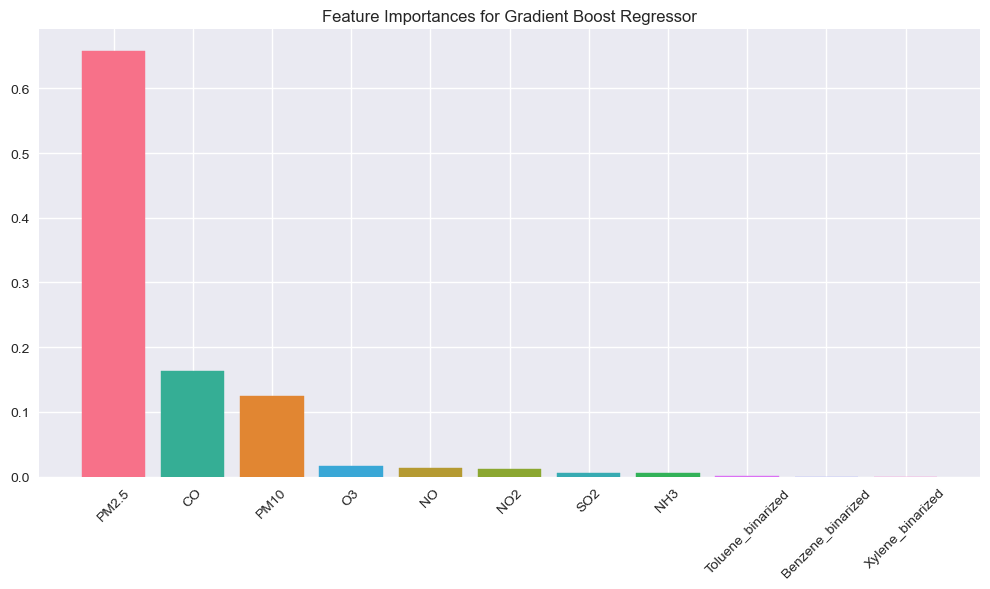

In [54]:
# Get feature importances
feature_importances = best_gradient_boosting_regressor.feature_importances_

# Sort feature importances in descending order and get the corresponding feature names
sorted_idx = feature_importances.argsort()[::-1]
feature_names = features.columns.tolist()  # Replace with your own feature names

# Define a custom color palette using Seaborn
n_colors = len(feature_names)
custom_palette = sns.color_palette("husl", n_colors=n_colors)

# Create a dictionary that maps feature names to colors
feature_colors = {feature_names[i]: custom_palette[i] for i in range(n_colors)}

# Plot feature importances with the custom color palette
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Gradient Boost Regressor")
bars = plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
for i, bar in enumerate(bars):
    feature_name = feature_names[sorted_idx[i]]
    color = feature_colors.get(feature_name, 'k')  # Default to black ('k') if color is not specified
    bar.set_color(color)
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
plt.tight_layout()
plt.show()

### Model Comparison 

In [76]:
# Create a DataFrame to store the results
results_data = {
    'Regressor': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Random Forest Regressor', 'AdaBoost Regressor', 'Bagging Regressor', 'Extra Trees Regressor', 'Gradient Boosting Regressor'],
    'Mean Squared Error (MSE)': [linearRegression_MSE, lassoRegression_MSE, ridgeRegression_MSE, randomForest_MSE, adaBoost_MSE, bagging_MSE, extra_trees_MSE, gradient_boosting_MSE],
    'Root Mean Squared Error (RMSE)': [linearRegression_RMSE, lassoRegression_RMSE, ridgeRegression_RMSE, randomForest_RMSE, adaBoost_RMSE, bagging_RMSE, extra_trees_RMSE, gradient_boosting_RMSE],
    'Mean Absolute Error (MAE)': [linearRegression_MAE, lassoRegression_MAE, ridgeRegression_MAE, randomForest_MAE, adaBoost_MAE, bagging_MAE, extra_trees_MAE, gradient_boosting_MAE],
    'R-squared (R2)': [linearRegression_R2, lassoRegression_R2, ridgeRegression_R2, randomForest_R2, adaBoost_R2, bagging_R2, extra_trees_R2, gradient_boosting_R2]
}

results_df = pd.DataFrame(results_data)
results_df

,Regressor,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
0,Linear Regression,0.088209,0.297001,0.224523,0.805426
1,Lasso Regression,0.109822,0.331394,0.250493,0.757753
2,Ridge Regression,0.088209,0.297000,0.224525,0.805427
3,Random Forest Regressor,0.034310,0.185229,0.126559,0.924319
4,AdaBoost Regressor,0.069451,0.263535,0.201716,0.846804
5,Bagging Regressor,0.034093,0.184642,0.125531,0.924798
6,Extra Trees Regressor,0.032731,0.180917,0.123001,0.927801
7,Gradient Boosting Regressor,0.034883,0.186769,0.130641,0.923055


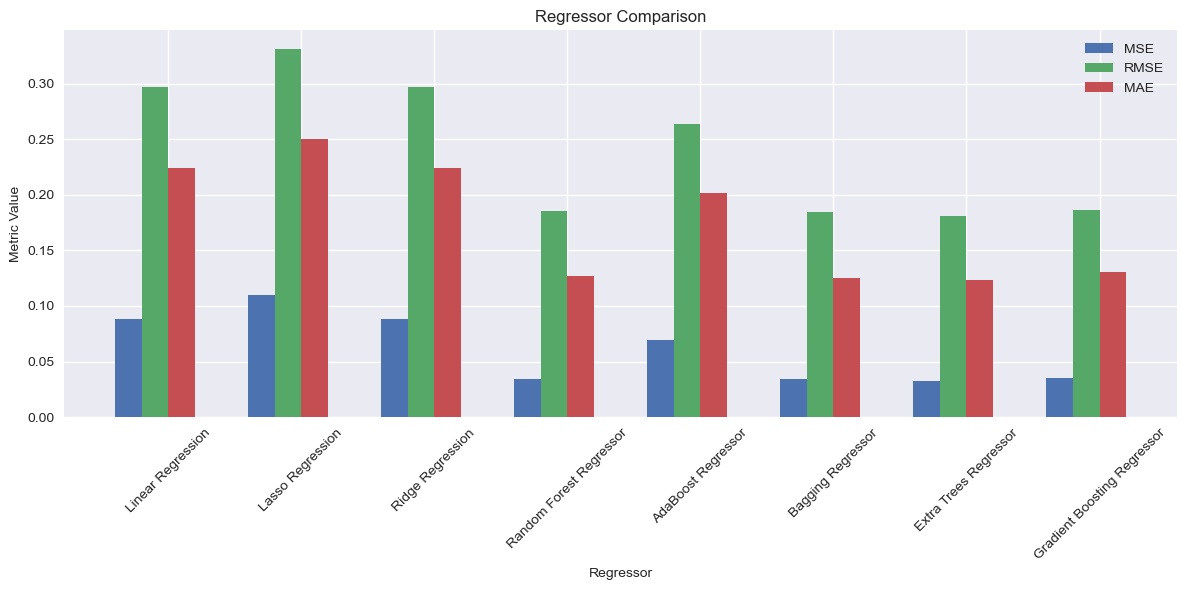

In [79]:
# Create grouped bar charts
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(results_df))

ax.bar(index, results_df['Mean Squared Error (MSE)'], bar_width, label='MSE')
ax.bar(index + bar_width, results_df['Root Mean Squared Error (RMSE)'], bar_width, label='RMSE')
ax.bar(index + 2 * bar_width, results_df['Mean Absolute Error (MAE)'], bar_width, label='MAE')

ax.set_xlabel('Regressor')
ax.set_ylabel('Metric Value')
ax.set_title('Regressor Comparison')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(results_df['Regressor'])
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()